### Create model input DEM from Moucha et al. (2011) Fig. 2
In this script I use Figure 2 from the 2011 study by Moucha et al. to create digitial elevational models to further use as model boundary conditions. This was necessary since the data is not publically available and Robert Moucha did not respond to data request. 

Prior to the processing shown hear, the sub-images in Fig. 2 where georeferenced using QGIS.

#### Processing steps:
1. The images where morphologically smoothed to get rid of small raster artifacts, noise etc. that's unnecessary for further processing
2. Reds between the RGB values RGB(160, 47, 31) and RGB(155, 43, 29) where masked and the resulting binary mask was smoothed using a maximum filter. The masked areas were then changed to pure red (RGB(255, 0 , 0) to account for the fact that dark red has less 'actual red' in it but has been used in the figure to show the strongest changes. This was problematic for further processing.
3. The image was then converted from RGB to LUV color space to make a grayscale conversion possible. This was necessary because dark blue and dark red result in the same grey values when converted. However, they show opposed values in the figure.
4. A maxiumum filter was used to minimize the red and black lines that signify some kind of region of interest in the figure, but should in the end not be converted to elevation values
5. The data was then normalized between the min and max values indicated in the figure (-1000, 1000) -> This seems to work for all scenes, since at least some pixels containing min max values are present in every image
6. The resulting data was then properly cropped to the extent of africa to get rid of slight changes in the land-sea configuration and to erase saudi arabia. Finally the data was safed as netcdf

In [8]:
# create a DEM from an RGB image
#-------------------------------

# here: use Moucha et al. 2011 Fig.2 to generate a DEM based on transient modelling of mantle convection and therefore dynamic topography in Africa during the Miocene

# import modules
#---------------
import rioxarray as rioxr #to easily work with multiband rasters
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from scipy import ndimage
import cv2 
import os
import glob
import geopandas as gpd
from shapely.geometry import mapping
import xarray as xr

# define functions
#-----------------
#define scaling function
def normalize(values, actual_bounds, desired_bounds):
    return [desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values]

#function for RGB to one channel gray
def rgb2grey(array, which):
    if which == 'opencv':
        red = array[:,:,0]
        green = array[:,:,1]
        blue = array[:,:,2]

    elif which == 'rioxarray':
        red = array.sel(band=1)
        green = array.sel(band=2)
        blue = array.sel(band=3)
        
    # luminosity method (factors are (offically) empirically determined)
    gryscl_img = (0.3 * red) + (0.59 * green) + (0.11 * blue)
    return(gryscl_img)

# I/O
#----
# working directory path
wd = '/home/niklaswerner/Documents/SU/MSc_thesis/model_setup/model_input/african_dem_generation_moucha/Moucha_fig2_georeferenced/'
# load shapefile of africa
africa_shp = gpd.read_file('/home/niklaswerner/Documents/SU/MSc_thesis/model_setup/model_input/african_dem_generation_moucha/calculations/ASS_outline/ASS_outline.shp', crs='epsg:4326')

# get all tif files from input directory
files = glob.glob(wd + '*.tif', recursive = False)
files = [f for f in files if os.path.isfile(f)]

#loop overall files for color and value conversion
for image in files:
    # read image with xarray for easy further processing
    img = rioxr.open_rasterio(image)

    #read image as opencv for color easy color conversions
    img_col = cv2.imread(image)     
    img_col = cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB)

    #replace dark red value by bright red for proper conversion to LUV color space; here: define color
    upper_red = np.array([160, 47, 31], dtype = 'uint16')
    lower_red = np.array([155, 43, 29], dtype = 'uint16')

    #get rid of the weird lines in the image as well as possible
    kernel = np.ones((10,10),np.uint8)
    img_col = cv2.morphologyEx(img_col, cv2.MORPH_OPEN, kernel)

    #replace red
    red_mask = cv2.inRange(img_col, lower_red, upper_red)
    mask_filtered = ndimage.maximum_filter(red_mask, size=15)
    img_col[mask_filtered>0]=(255,0,0)

    # calculate grayscale from RGB bands
    #-----------------------------------
    # merge bands to one (to keep the spatial reference in the when assgining the opencv color changed image)
    img_single_chn = rgb2grey(img, 'rioxarray')

    # mask water (e.i. set values of 255. to none)
    #---------------------------------------------
    #due to problems with the grid lines 230 empirically seemed to be the optimal values to get rid of them
    water_mask = xr.where(img_single_chn >= 230, False, True)
    #gryscl_masked.plot.imshow()

    #convert image to LUV color space
    img_luv = cv2.cvtColor(img_col, cv2.COLOR_RGB2LUV)
    img_luv_single_chn = rgb2grey(img_luv,'opencv')

    # assign new values to xarray datase
    img_single_chn.values = img_luv_single_chn
    img_masked = img_single_chn.where(water_mask, drop=True)

    # filter to get rid of the lines from the figure
    #-----------------------------------------------
    # using maximum filter
    img_copy = img_masked.copy()
    img_copy.values = ndimage.maximum_filter(img_masked, size=6)

    #img_copy.values = ndimage.laplace(img_masked)
    # convert grayscale to meters dynamic topography
    #-----------------------------------------------
    if '25ma' in image:
        bnd_low = -400
        bnd_up = 500 
    elif '20ma' in image:
        bnd_low = -500
        bnd_up = 1000
    elif '15ma' in image:
        bnd_low = -700
        bnd_up = 1000
    elif '10ma' in image:
        bnd_low = -1000
        bnd_up = 1000
    elif '05ma' in image:
        bnd_low = -1000
        bnd_up = 1000
    elif '00ma' in image:
        bnd_low = -1000
        bnd_up = 1000
        
    # this is done by merely using the min/max values from the legend of Moucha et al. 2011 Fig 2 as lower and upper boundary
    img_copy.values = normalize(img_copy.values, (np.nanmin(img_copy.values), np.nanmax(img_copy.values)), (bnd_low, bnd_up)) 
   
    # clip to shapefile extent to get grid of land sea mask changes and saudi arabia
    img_clipped = img_copy.rio.clip(africa_shp.geometry.apply(mapping), africa_shp.crs, drop=False)
    
    # rename coordinates for proper postprocessing to lat/lon
    img_clipped = img_clipped.rename({'x':'lon','y':'lat'})
    
    # rename data array so the data acutally has a name when converted to netcdf
    img_clipped = img_clipped.rename('dyntopo_ref30Ma')
    
    # create output filename
    img_clipped.to_netcdf(image[0:96] + '/calculations/' + image[123:].removesuffix('.tif') + '_processed.nc')
    
    # plot if wanted
    #plt.imshow(img_clipped)               
    #plt.savefig(image.removesuffix('.tif') + '_processed_plot.tif')
                             


ERROR 1: PROJ: proj_identify: /home/niklaswerner/anaconda3/envs/schiaparelli_velo_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/niklaswerner/anaconda3/envs/schiaparelli_velo_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/niklaswerner/anaconda3/envs/schiaparelli_velo_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/niklaswerner/anaconda3/envs/schiaparelli_velo_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/niklaswerner/anaconda3/envs/schiaparelli_velo_env/share/proj/proj.db

In [ ]:
#-------------------------- CDO processing ---------------------------------------
# run moucha2dem.sh bash script
#-------------------------------
import subprocess
bsh_path = '/home/niklaswerner/Documents/SU/MSc_thesis/model_setup/model_input/african_dem_generation_moucha/calculations/'
subprocess.call(bsh_path + 'moucha2dem_modin.sh', shell=True)

# or run the moucha2dem.sh bash script manually if it doesn't work with python

The output fro the above script is then used as input for the *moucha2dem.sh* bash script. When using the bash script, make sure the output data from above and the script are in the same directory. The script does not contain error handling so make sure you have proper input. 

Since the Moucha et al. (2011) is dynamic topography (i.e. changes in topography) in reference to the 30 Ma topography, I used the following steps to combine the new topography with the former model input file:
1. Mask Africa and calculate the difference between the dyanmic topography at each time step (5, 10, 15, 20, 25 Ma) and present day dynamic topography in reference to 30 Ma. This gets us the difference in elevation between each step and the present day.
2. This elevation difference was then subtracted from the original DEM topography within the Africa mask to get absolute elevation values for each time step

NOTE: It seems that especially in the early Miocene some areas have been below sea level that are above sea level nowadays. The question remains whether these areas can be kept below sea level or should be set to sea level.

### Plot results after bash processing for sanity check

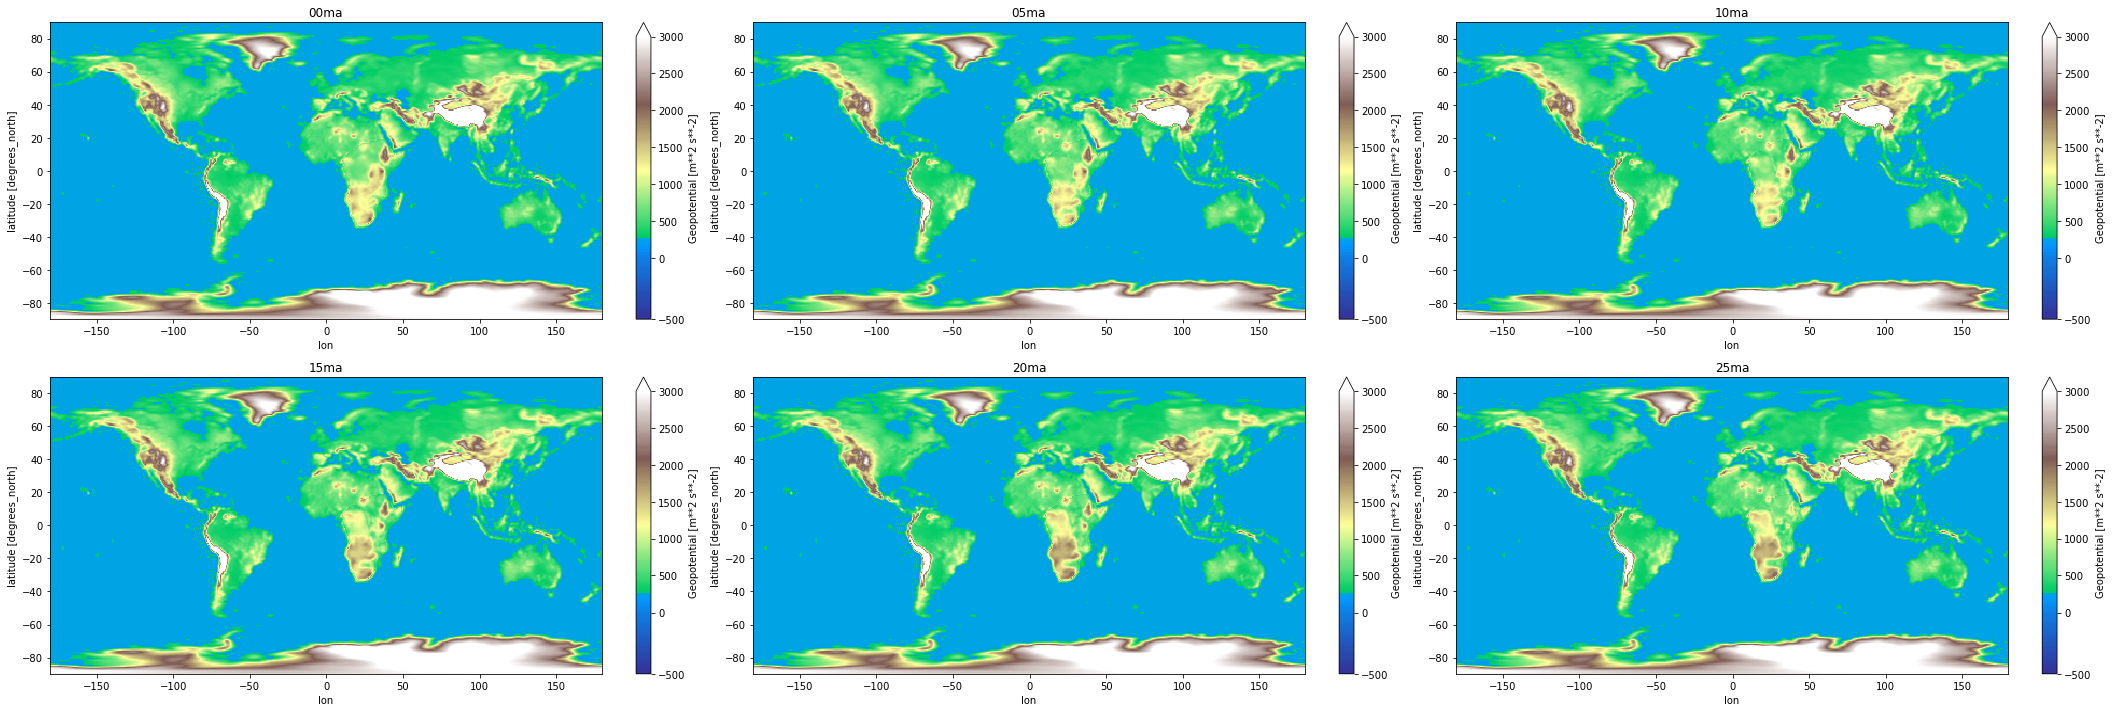

In [77]:
# plot results after bshscripting for sanity check
#--------------------------------------------------
wd2 = '/home/niklaswerner/Documents/SU/MSc_thesis/model_setup/model_input/african_dem_generation_moucha/calculations/model_input_dems/'

files = glob.glob(wd2 + '*modIn.nc', recursive = False)
files = [f for f in files if os.path.isfile(f)]

xrlist = []
for img in sorted(files):
    proc_img = xr.open_dataset(img)
    proc_img.coords['lon'] = (proc_img.coords['lon'] + 180) % 360 - 180
    proc_img = proc_img.sortby(proc_img.lon)

    mask_lon = (proc_img.lon >= -180) & (proc_img.lon <= 180)
    mask_lat = (proc_img.lat >= -90) & (proc_img.lat <= 90)

    subset =  proc_img['z'].where(mask_lon & mask_lat, drop=True)
    xrlist.append(subset)
    
    
import matplotlib
class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a co
    lormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)

plt.figure(figsize=(30, 10))
#plt.subplots_adjust(vspace=0.5)
plt.title("Topography changes Miocene", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, img in enumerate(xrlist):
    # add a new subplot iteratively
    ax = plt.subplot(2, 3, n + 1)
    norm = FixPointNormalize(sealevel=5, vmin=-500, vmax=3000)
    img.plot(ax=ax, norm=norm, cmap=cut_terrain_map)
    
    ax.set_title(sorted(files)[n][147:151])
    plt.tight_layout()
    plt.savefig('/home/niklaswerner/Desktop/topo_update_20220914.png', dpi=300)